<a href="https://colab.research.google.com/github/nicole-yoong/Portfolio/blob/main/Diabetes_Detection/%5BPart_4%5D_Unsupervised_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

print("Setup complete.")

Setup complete.


# Loading data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Python/Case Studies/DM Coursework 2/DiabetesClassificationDataset2022.csv')
df.head(5)

,encounter_id,hospital_id,gender,ethnicity,age,elective_surgery,height,weight,bmi,readmission_status,...,map_apache,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,ventilated_apache,diabetes_mellitus
0,214826,118,M,Caucasian,68.0,0,180.3,73.9,22.732803,0,...,40.0,0,0,0,0,0,0,0,0,1
1,276985,118,F,Caucasian,25.0,0,172.7,95.3,31.952749,0,...,68.0,0,0,0,0,0,0,0,0,0
2,262220,118,F,Caucasian,81.0,1,165.1,61.7,22.635548,0,...,60.0,0,0,0,0,0,0,0,1,0
3,201746,33,M,Caucasian,19.0,0,188.0,NaN,NaN,0,...,103.0,0,0,0,0,0,0,0,0,0
4,246060,81,F,Caucasian,77.0,0,160.0,70.2,27.421875,0,...,46.0,0,0,0,0,0,0,0,1,1


# Data exploration

Download the dataset and prepare a summary of the features available on the 
dataset including data type (numerical/ categorical), amount of missing data in 
individual fields. This can be included as an appendix.


In [5]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79159 entries, 0 to 79158
Data columns (total 88 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   encounter_id                 79159 non-null  int64  
 1   hospital_id                  79159 non-null  int64  
 2   gender                       79129 non-null  object 
 3   ethnicity                    78198 non-null  object 
 4   age                          76317 non-null  float64
 5   elective_surgery             79159 non-null  int64  
 6   height                       77978 non-null  float64
 7   weight                       77086 non-null  float64
 8   bmi                          76468 non-null  float64
 9   readmission_status           79159 non-null  int64  
 10  icu_type                     79159 non-null  object 
 11  h1_temp_max                  61223 non-null  float64
 12  h1_temp_min                  61223 non-null  float64
 13  d1_albumin_max  

(79159, 88)

# Missing values

In [6]:
#check how many missing values in each column

total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Missing %'])
missing_data.head(35)


,Total,Missing %
h1_bilirubin_min,72849,0.920287
h1_bilirubin_max,72849,0.920287
h1_albumin_min,72271,0.912985
h1_albumin_max,72271,0.912985
h1_lactate_min,71985,0.909372
h1_lactate_max,71985,0.909372
h1_pao2fio2ratio_max,68816,0.869339
h1_pao2fio2ratio_min,68816,0.869339
h1_arterial_ph_max,65389,0.826046
h1_arterial_ph_min,65389,0.826046


In [7]:
#dealing with missing data
df = df.drop((missing_data[missing_data['Missing %'] > 0.6]).index,1)
df.isnull().sum().max() #just checking that there's no missing data missing...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


46477

## Random fill-in

In [8]:
from random import choice

mask = df["gender"].isna()
df.loc[mask,["gender"]] = df.loc[mask,["gender"]].applymap(lambda _: choice(["M","F"]))

In [9]:
mask = df["ethnicity"].isna()
df.loc[mask,["ethnicity"]] = df.loc[mask,["ethnicity"]].applymap(lambda _: choice(["Caucasian","African American",
                                                                             'Other/Unknown', 'Hispanic', 'Asian', 'Native American']))

## Imputation 

In [10]:
imp_df= df.fillna(method='bfill', axis=0).fillna(0)
imp_df.describe() 

,encounter_id,hospital_id,age,elective_surgery,height,weight,bmi,readmission_status,h1_temp_max,h1_temp_min,...,map_apache,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,ventilated_apache,diabetes_mellitus
count,79159.000000,79159.000000,79159.000000,79159.000000,79159.000000,79159.000000,79159.000000,79159.0,79159.000000,79159.000000,...,79159.000000,79159.000000,79159.000000,79159.000000,79159.000000,79159.000000,79159.000000,79159.000000,79159.000000,79159.000000
mean,212863.726740,106.188620,62.454036,0.189404,169.565825,85.141136,29.602947,0.0,36.721336,36.612534,...,87.269899,0.000834,0.016713,0.013744,0.025379,0.007327,0.004080,0.020781,0.332243,0.355639
std,38113.816591,63.776527,16.451232,0.391831,10.831737,25.462159,8.485454,0.0,0.769038,0.793106,...,42.058765,0.028863,0.128195,0.116429,0.157275,0.085284,0.063748,0.142651,0.471020,0.478709
min,147001.000000,1.000000,0.000000,0.000000,137.200000,38.600000,14.844926,0.0,33.400000,32.900000,...,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,179772.000000,49.000000,53.000000,0.000000,162.500000,67.800000,23.876404,0.0,36.400000,36.300000,...,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,212864.000000,112.000000,65.000000,0.000000,170.000000,81.600000,28.039729,0.0,36.700000,36.700000,...,66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,245812.000000,165.000000,75.000000,0.000000,177.800000,98.430000,33.421693,0.0,37.100000,37.000000,...,124.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,278997.000000,204.000000,89.000000,1.000000,195.590000,186.000000,67.814990,0.0,39.500000,39.300000,...,200.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df = imp_df

# Dropping not useful columnns

In [12]:
#drop the columns that are not useful
df = df.loc[:, ~df.columns.isin(["encounter_id", "hospital_id", 'height', 'weight','readmission_status'])]

# Dropping highly correlated columns

In [13]:
X = df.loc[:, ~df.columns.isin(['diabetes_mellitus'])]

#extract the target column
y = df["diabetes_mellitus"] 

In [14]:
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print(); print(to_drop)


['d1_albumin_min', 'd1_bilirubin_min', 'd1_bun_min', 'd1_platelets_min', 'd1_wbc_min', 'h1_glucose_min']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [15]:
df = df.loc[:, ~df.columns.isin(['d1_albumin_min', 'd1_bilirubin_min', 'd1_bun_min', 'd1_platelets_min', 'd1_wbc_min', 'h1_glucose_min'])]

# Categorical and Numerical 

In [16]:
pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 8.0 MB/s 


In [17]:
#divide our columns in to the categorical and numerical columns for variables that are useful for prediction of diabetes

cat_col = ["gender", "ethnicity", "icu_type"]
num_col = df.loc[:, ~df.columns.isin(["gender", "ethnicity", "icu_type"])]

In [18]:
#Let us run loop of value_counts of each column to find out unique values. 
for col in df[cat_col]:
    print ("---- %s ---" % col)
    print (df[col].value_counts())

---- gender ---
M    42925
F    36234
Name: gender, dtype: int64
---- ethnicity ---
Caucasian           60545
African American     8965
Other/Unknown        4049
Hispanic             3312
Asian                1507
Native American       781
Name: ethnicity, dtype: int64
---- icu_type ---
Med-Surg ICU    43608
MICU             6816
CCU-CTICU        6809
Neuro ICU        6077
Cardiac ICU      5069
SICU             4902
CSICU            3138
CTICU            2740
Name: icu_type, dtype: int64


## Label encoding

In [19]:
from sklearn.preprocessing import LabelEncoder

for col in ["ethnicity", "icu_type", 'gender']:
    df[col] = LabelEncoder().fit_transform(df[col])

In [20]:
df

,gender,ethnicity,age,elective_surgery,bmi,icu_type,h1_temp_max,h1_temp_min,d1_albumin_max,d1_bilirubin_max,...,map_apache,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,ventilated_apache,diabetes_mellitus
0,1,2,68.0,0,22.732803,2,39.5,37.5,2.3,0.4,...,40.0,0,0,0,0,0,0,0,0,1
1,0,2,25.0,0,31.952749,5,36.7,36.7,1.6,0.5,...,68.0,0,0,0,0,0,0,0,0,0
2,0,2,81.0,1,22.635548,2,35.6,34.8,1.6,0.5,...,60.0,0,0,0,0,0,0,0,1,0
3,1,2,19.0,0,27.421875,5,36.3,36.3,1.6,0.5,...,103.0,0,0,0,0,0,0,0,0,0
4,0,2,77.0,0,27.421875,5,36.3,36.3,1.6,0.5,...,46.0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79154,0,2,86.0,0,30.687339,5,36.7,36.7,2.6,0.4,...,137.0,0,0,0,0,0,0,0,0,0
79155,0,2,55.0,0,33.641487,4,36.6,36.6,2.6,0.4,...,59.0,0,0,0,1,0,0,1,0,0
79156,1,0,61.0,0,29.436333,2,36.8,36.8,2.6,0.4,...,173.0,0,0,0,0,0,0,0,0,0
79157,1,2,80.0,0,27.689796,0,36.9,35.7,2.0,0.2,...,54.0,0,0,0,1,0,0,0,0,0


# Feature Selection

In [21]:
X = df.loc[:, ~df.columns.isin(["diabetes_mellitus"])]
y = df["diabetes_mellitus"] 

In [22]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import chi2

selector = SelectKBest(score_func=mutual_info_classif, k='all')

# transform train input data
Xfs = selector.fit_transform(X,y)

In [23]:
names = X.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'Mutual_info'])
ns_df_sorted = ns_df.sort_values(['Mutual_info', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

                     Feat_names  Mutual_info
20               h1_glucose_max     0.078340
4                           bmi     0.031273
11               d1_glucose_min     0.026801
10                   d1_bun_max     0.023971
27            creatinine_apache     0.023683
9              d1_bilirubin_max     0.013799
2                           age     0.011151
21                   wbc_apache     0.010231
1                     ethnicity     0.009031
26              gcs_eyes_apache     0.007251
25             gcs_motor_apache     0.006298
5                      icu_type     0.005775
15             d1_potassium_max     0.005267
19                   d1_wbc_max     0.004523
18                d1_sodium_min     0.004087
17                d1_sodium_max     0.004050
7                   h1_temp_min     0.003686
28                  h1_spo2_max     0.003249
16             d1_potassium_min     0.002755
37            ventilated_apache     0.002225
8                d1_albumin_max     0.001672
30        

# K-Means Clustering

## Without feature selection 

In [24]:
X = df.loc[:, ~df.columns.isin(["diabetes_mellitus"])]
                               
labels_true = df["diabetes_mellitus"] 

pipe_dt=Pipeline([('scl',StandardScaler()),
                 ('pca',PCA(n_components=2))
                 ])

X = pipe_dt.fit_transform(X)

In [25]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,12)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1024).fit(X)
    kmeans.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

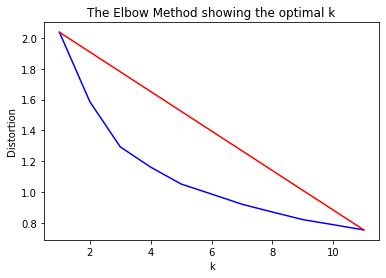

In [26]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [27]:
kmeans = KMeans(n_clusters=2, random_state=1024)
y_pred = kmeans.fit_predict(X)
labels_pred = y_pred
labels_pred

array([0, 0, 1, ..., 0, 0, 1], dtype=int32)

### Evaluation

#### Accuracy score 

In [28]:
# check how many of the samples were correctly labeled
correct_labels = sum(labels_true == labels_pred)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, labels_true.size))

Result: 45249 out of 79159 samples were correctly labeled.


In [29]:
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(labels_true.size)))

Accuracy score: 0.57


#### Classification report 

In [30]:
def converter(cluster):
    if cluster==1:
        return 1
    else:
        return 0

In [31]:
df['Cluster'] = df['diabetes_mellitus'].apply(converter)

In [32]:
print(classification_report(df['Cluster'],kmeans.labels_))

              precision    recall  f1-score   support

           0       0.65      0.74      0.69     51007
           1       0.36      0.26      0.31     28152

    accuracy                           0.57     79159
   macro avg       0.50      0.50      0.50     79159
weighted avg       0.54      0.57      0.55     79159



#### Adjusted rand score

In [33]:
score = adjusted_rand_score(labels_true, labels_pred)
score

0.0014864144876934973

#### Adjusted mutual info score

In [34]:
score = adjusted_mutual_info_score(labels_true, labels_pred)
score

2.1049729111586998e-05

## With feature selection

In [35]:
X = df.loc[:, df.columns.isin(['h1_glucose_max', 'd1_glucose_min', 'bmi', 'd1_bun_max', 'creatinine_apache', 
                               'd1_bilirubin_max'])]
                               
labels_true = df["diabetes_mellitus"] 

pipe_dt=Pipeline([('scl',StandardScaler()),
                 ('pca',PCA(n_components=2))
                 ])

X = pipe_dt.fit_transform(X)

In [36]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,12)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1024).fit(X)
    kmeans.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

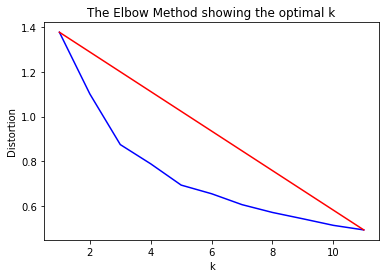

In [37]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [38]:
kmeans = KMeans(n_clusters=2, random_state=1024)
y_pred = kmeans.fit_predict(X)
labels_pred = y_pred
labels_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

### Evaluation

#### Accuracy score 

In [39]:
# check how many of the samples were correctly labeled
correct_labels = sum(labels_true == labels_pred)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, labels_true.size))

Result: 51500 out of 79159 samples were correctly labeled.


In [40]:
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(labels_true.size)))

Accuracy score: 0.65


#### Classification report 

In [41]:
print(classification_report(df['Cluster'],kmeans.labels_))

              precision    recall  f1-score   support

           0       0.67      0.89      0.77     51007
           1       0.52      0.21      0.30     28152

    accuracy                           0.65     79159
   macro avg       0.60      0.55      0.53     79159
weighted avg       0.62      0.65      0.60     79159



#### Confusion matrix 

([<matplotlib.axis.YTick at 0x7f790fda0150>,
 [Text(0, 0.5, 'False'), Text(0, 1.5, 'True')])

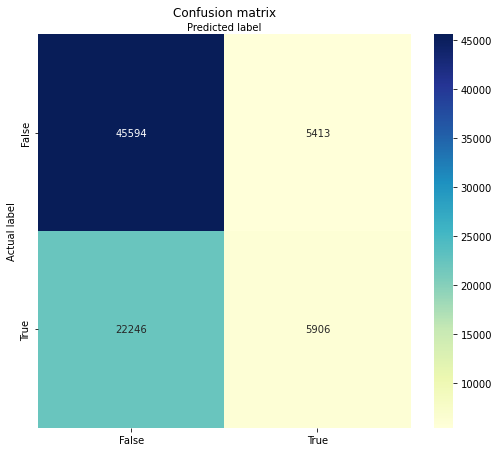

In [42]:
cnf_matrix = confusion_matrix(df['Cluster'],kmeans.labels_)

%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#### Adjusted rand score

In [43]:
score = adjusted_rand_score(labels_true, labels_pred)
score

0.0503435265244196

#### Adjusted mutual info score

In [44]:
score = adjusted_mutual_info_score(labels_true, labels_pred)
score

0.01820162584823436

# Visualization

In [45]:
tsne = TSNE(verbose = 1, perplexity = 50)
Y = tsne.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 79159 samples in 0.032s...
[t-SNE] Computed neighbors for 79159 samples in 1.793s...
[t-SNE] Computed conditional probabilities for sample 1000 / 79159
[t-SNE] Computed conditional probabilities for sample 2000 / 79159
[t-SNE] Computed conditional probabilities for sample 3000 / 79159
[t-SNE] Computed conditional probabilities for sample 4000 / 79159
[t-SNE] Computed conditional probabilities for sample 5000 / 79159
[t-SNE] Computed conditional probabilities for sample 6000 / 79159
[t-SNE] Computed conditional probabilities for sample 7000 / 79159
[t-SNE] Computed conditional probabilities for sample 8000 / 79159
[t-SNE] Computed conditional probabilities for sample 9000 / 79159
[t-SNE] Computed conditional probabilities for sample 10000 / 79159
[t-SNE] Computed conditional probabilities for sample 11000 / 79159
[t-SNE] Computed conditional probabilities for sample 12000 / 79159
[t-SNE] Computed conditional probabilities for sa

Text(0.5, 1.0, 'Actual clusters')

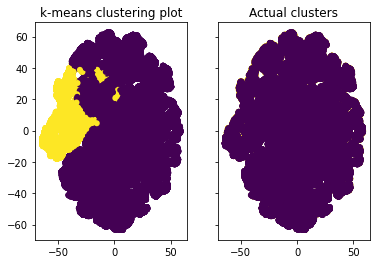

In [46]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(Y[:,0],Y[:,1],  c=labels_pred, edgecolor = "None")
ax1.set_title('k-means clustering plot')

ax2.scatter(Y[:,0],Y[:,1],  c = df["diabetes_mellitus"], edgecolor = "None")
ax2.set_title('Actual clusters')